In [1]:
!pip install ultralytics torch torchvision torchaudio scikit-learn opencv-python

     ---------------------------------------- 1.1/1.1 MB 1.4 MB/s eta 0:00:00
     -------------------------------------- 111.0/111.0 MB 2.3 MB/s eta 0:00:00
     ---------------------------------------- 4.0/4.0 MB 807.9 kB/s eta 0:00:00
     -------------------------------------- 664.7/664.7 kB 3.0 MB/s eta 0:00:00
     ---------------------------------------- 8.1/8.1 MB 2.7 MB/s eta 0:00:00
     ---------------------------------------- 8.1/8.1 MB 1.8 MB/s eta 0:00:00
     ---------------------------------------- 7.0/7.0 MB 2.2 MB/s eta 0:00:00
     -------------------------------------- 158.8/158.8 kB 1.9 MB/s eta 0:00:00
     ---------------------------------------- 64.7/64.7 kB 3.4 MB/s eta 0:00:00
     ---------------------------------------- 38.7/38.7 MB 2.6 MB/s eta 0:00:00
     -------------------------------------- 802.4/802.4 kB 5.1 MB/s eta 0:00:00
     ---------------------------------------- 6.3/6.3 MB 2.8 MB/s eta 0:00:00
     ---------------------------------------- 2.1/


[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os, glob, math, json, time, collections, random
import numpy as np
import cv2
from pathlib import Path

import torch, torch.nn as nn, torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from ultralytics import YOLO

from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms



# Utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

def make_dirs(d):
    os.makedirs(d, exist_ok=True)

def timestamp():
    return time.strftime('%Y%m%d_%H%M%S')


ModuleNotFoundError: No module named 'pandas'

In [25]:
class AdaptiveKeyframeExtractor:
    """
    Adaptive keyframe extraction for 1-3 second action videos.

    Strategy:
    - < 1s: Use ALL frames + repeat to reach target
    - 1-2s: Uniform sampling
    - > 2s: Dense sampling in middle 60% (action region)
    """

    def __init__(self, target_frames=16):
        self.target_frames = target_frames

    def extract_frame_indices(self, video_path):

        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        duration = total_frames / fps if fps > 0 else 0
        cap.release()

        if duration > 0:
            # Very short: use ALL frames
            indices = list(range(total_frames))

            # Handle case where video has no frames
            if len(indices) == 0:
                return []

            # Repeat frames to reach target
            if len(indices) < self.target_frames:
                repeat_factor = self.target_frames / len(indices)
                new_indices = []
                for i in indices:
                    n_repeats = int(np.ceil(repeat_factor))
                    new_indices.extend([i] * n_repeats)
                indices = new_indices[:self.target_frames]

        # elif duration <= 2.0:
        #     # Medium: uniform sampling
        #     if total_frames <= self.target_frames:
        #         indices = list(range(total_frames))
        #     else:
        #         step = total_frames / self.target_frames
        #         indices = [int(i * step) for i in range(self.target_frames)]

        # else:
        #     # Longer: dense middle sampling (skip first 20% and last 20%)
        #     start_frame = int(total_frames * 0.2)
        #     end_frame = int(total_frames * 0.8)
        #     action_frames = end_frame - start_frame

        #     # Ensure action_frames is not zero or negative for division
        #     if action_frames <= 0:
        #         # If the action region is empty or invalid, just sample uniformly or return empty
        #         if total_frames <= self.target_frames:
        #             indices = list(range(total_frames))
        #         else:
        #             step = total_frames / self.target_frames
        #             indices = [int(i * step) for i in range(self.target_frames)]
        #     else:
        #         step = max(1, action_frames // self.target_frames)
        #         indices = [start_frame + i * step for i in range(self.target_frames)]

        return indices[:self.target_frames]

In [26]:

# KEYPOINT EXTRACTOR

class KeypointExtractor:
    """Extract human pose keypoints using YOLO11 pose model."""

    def __init__(self, device='cpu'):
        print("Loading YOLO11 Pose model...")
        self.model = YOLO('yolo11n-pose.pt')  # Nano pose model
        self.device = device
        self.feature_dim = 51  # 17 keypoints × 3 (x, y, confidence)

    def extract(self, frame):
        """Extract keypoints from frame.

        Returns:
            np.array of shape (51,): flattened [x1,y1,conf1, x2,y2,conf2, ...]
        """
        try:
            results = self.model(frame, imgsz=640, device=self.device, verbose=False)

            if len(results) == 0 or not hasattr(results[0], 'keypoints'):
                return np.zeros(self.feature_dim, dtype=np.float32)

            kpts = results[0].keypoints

            if kpts is None or len(kpts) == 0:
                return np.zeros(self.feature_dim, dtype=np.float32)

            # Get first person's keypoints
            kpt_data = kpts.data[0].cpu().numpy()  # Shape: (17, 3)

            # Normalize coordinates by frame dimensions
            h, w = frame.shape[:2]
            kpt_data[:, 0] /= w  # Normalize x
            kpt_data[:, 1] /= h  # Normalize y

            # Flatten to 1D
            features = kpt_data.flatten()

            return features.astype(np.float32)

        except Exception as e:
            print(f"Keypoint extraction failed: {e}")
            return np.zeros(self.feature_dim, dtype=np.float32)


# FEATURE CACHE


class VideoFeatureCache:

    def __init__(self, cache_dir):
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(parents=True, exist_ok=True)

    def cache_path(self, video_path):
        fname = Path(video_path).stem + '.npy'
        return self.cache_dir / fname

    def exists(self, video_path):
        return self.cache_path(video_path).exists()

    def save(self, video_path, arr):
        try:
            np.save(str(self.cache_path(video_path)), arr)
        except Exception as e:
            print(f"Warning: Failed to save cache for {video_path}: {e}")

    def load(self, video_path):
        try:
            return np.load(str(self.cache_path(video_path)))
        except Exception as e:
            print(f"Warning: Failed to load cache for {video_path}: {e}")
            return None


# ADAPTIVE FEATURE EXTRACTION

def precompute_keypoint_features_adaptive(videos, extractor, cache, seq_length=16):
    """Pre-extract keypoint features with adaptive sampling."""

    print("\n" + "="*60)
    print("ADAPTIVE KEYFRAME EXTRACTION + FEATURE EXTRACTION")
    print("="*60)

    keyframe_extractor = AdaptiveKeyframeExtractor(target_frames=seq_length)
    feature_dim = extractor.feature_dim
    videos_to_process = [v for v in videos if not cache.exists(v)]

    if len(videos_to_process) == 0:
        print("✓ All features already cached!")
        return

    print(f"Processing {len(videos_to_process)} videos...\n")

    for video_path in tqdm(videos_to_process, desc="Extracting features"):
        try:
            # Get adaptive frame indices
            frame_indices = keyframe_extractor.extract_frame_indices(video_path)

            # Extract features from selected frames
            cap = cv2.VideoCapture(video_path)
            feats = []

            for frame_idx in frame_indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
                ok, frame = cap.read()

                if not ok:
                    break

                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                feat = extractor.extract(frame)
                feats.append(feat)

            cap.release()

            # Pad if needed (shouldn't happen with adaptive)
            if len(feats) < seq_length:
                if len(feats) == 0:
                    feats = [np.zeros(feature_dim, dtype=np.float32)] * seq_length
                else:
                    last = feats[-1]
                    while len(feats) < seq_length:
                        feats.append(last.copy())

            arr = np.stack(feats[:seq_length], axis=0).astype(np.float32)
            cache.save(video_path, arr)

        except Exception as e:
            print(f"\nError: {video_path}: {e}")
            zero_features = np.zeros((seq_length, feature_dim), dtype=np.float32)
            cache.save(video_path, zero_features)

    print("\n✓ Feature extraction complete!")




Dataset + Augmentation + load pre-extracted features

In [27]:
class PickleballDataset(Dataset):

    def __init__(self, videos, labels, cache, seq_length=16,
                 augment=False, feature_dim=2048):
        self.videos = videos
        self.labels = labels
        self.cache = cache
        self.seq_length = seq_length
        self.augment = augment
        self.feature_dim = feature_dim

    def __len__(self):
        return len(self.videos)

    # RANDOM MASKING AUGMENTATION


    def random_keypoint_masking(self, features, mask_prob=0.15, mask_strategy='random'):
        """
        Randomly mask keypoints to simulate occlusion and improve robustness.

        Args:
            features: (seq_len, 51) array of keypoint features
            mask_prob: Probability of masking each keypoint (0.0-1.0)
            mask_strategy: 'random', 'body_part', 'temporal', or 'mixed'

        Returns:
            Masked features
        """
        features = features.copy()
        seq_len = features.shape[0]

        if mask_strategy == 'random':
            # 1: Random individual keypoint masking
            for t in range(seq_len):
                frame = features[t].reshape(17, 3)  # 17 keypoints × 3 values

                for kp_idx in range(17):
                    if random.random() < mask_prob:
                        # Mask this keypoint (set to zeros)
                        frame[kp_idx] = [0, 0, 0]

                features[t] = frame.flatten()

        elif mask_strategy == 'body_part':
            # 2: Mask entire body parts
            # Define body part groups
            body_parts = {
                'head': [0, 1, 2, 3, 4],  # nose, eyes, ears
                'left_arm': [5, 7, 9],    # left shoulder, elbow, wrist
                'right_arm': [6, 8, 10],  # right shoulder, elbow, wrist
                'torso': [5, 6, 11, 12],  # shoulders, hips
                'left_leg': [11, 13, 15], # left hip, knee, ankle
                'right_leg': [12, 14, 16] # right hip, knee, ankle
            }

            for t in range(seq_len):
                frame = features[t].reshape(17, 3)

                # Randomly mask 0-2 body parts per frame
                n_parts_to_mask = random.randint(0, 2)
                parts_to_mask = random.sample(list(body_parts.keys()), n_parts_to_mask)

                for part_name in parts_to_mask:
                    for kp_idx in body_parts[part_name]:
                        frame[kp_idx] = [0, 0, 0]

                features[t] = frame.flatten()

        elif mask_strategy == 'temporal':
            # 3: Mask keypoints across multiple consecutive frames
            #

            # Choose 1-3 keypoints to mask temporally
            n_keypoints = random.randint(1, 3)
            keypoints_to_mask = random.sample(range(17), n_keypoints)

            for kp_idx in keypoints_to_mask:
                # Mask for 2-5 consecutive frames
                mask_duration = random.randint(2, 5)
                start_frame = random.randint(0, max(0, seq_len - mask_duration))

                for t in range(start_frame, min(start_frame + mask_duration, seq_len)):
                    frame = features[t].reshape(17, 3)
                    frame[kp_idx] = [0, 0, 0]
                    features[t] = frame.flatten()

        elif mask_strategy == 'mixed':
            # 4: Combine all strategies with random selection
            strategy = random.choice(['random', 'body_part', 'temporal'])
            return self.random_keypoint_masking(features, mask_prob, strategy)

        return features

    def random_confidence_noise(self, features, noise_std=0.1):
        """
        Add noise to confidence scores to simulate YOLO uncertainty.

        Args:
            features: (seq_len, 51) array
            noise_std: Standard deviation of noise to add to confidence
        """
        features = features.copy()
        seq_len = features.shape[0]

        for t in range(seq_len):
            frame = features[t].reshape(17, 3)

            # Add noise to confidence (3rd column)
            confidence_noise = np.random.normal(0, noise_std, 17)
            frame[:, 2] = np.clip(frame[:, 2] + confidence_noise, 0, 1)

            features[t] = frame.flatten()

        return features

    def random_low_confidence_masking(self, features, conf_threshold=0.3):
        """
        Mask keypoints with low confidence (simulates poor detection).

        Args:
            features: (seq_len, 51) array
            conf_threshold: Mask keypoints with confidence below this
        """
        features = features.copy()
        seq_len = features.shape[0]

        for t in range(seq_len):
            frame = features[t].reshape(17, 3)

            # Find low-confidence keypoints
            low_conf_mask = frame[:, 2] < conf_threshold

            # Mask them
            frame[low_conf_mask] = [0, 0, 0]

            features[t] = frame.flatten()

        return features





    def temporal_augmentation(self, features):
        """Apply temporal augmentation to feature sequence."""
        seq_len = features.shape[0]

        # Random temporal shift (±20% of sequence)
        if random.random() < 0.5:
            shift = random.randint(-seq_len // 5, seq_len // 5)
            if shift > 0:
                # Shift right: pad left, trim right
                features = np.concatenate([
                    np.repeat(features[0:1], shift, axis=0),
                    features[:-shift]
                ], axis=0)
            elif shift < 0:
                # Shift left: trim left, pad right
                features = np.concatenate([
                    features[-shift:],
                    np.repeat(features[-1:], -shift, axis=0)
                ], axis=0)

        # Random temporal dropout (drop 1-2 frames, duplicate neighbors)
        if random.random() < 0.3:
            num_drops = random.randint(1, 2)
            for _ in range(num_drops):
                drop_idx = random.randint(1, seq_len - 2)
                # Replace dropped frame with average of neighbors
                features[drop_idx] = (features[drop_idx-1] + features[drop_idx+1]) / 2

        # Random temporal reverse (for symmetric actions)
        if random.random() < 0.2:
            features = features[::-1].copy()

        return features



    def add_feature_noise(self, x, std=0.01):
        """Add small Gaussian noise to precomputed features."""
        noise = np.random.normal(0, std, x.shape).astype(np.float32)
        return x + noise

    def frame_dropout(self, x, max_drops=3):
        L = x.shape[0]
        drops = random.randint(1, max_drops)
        idxs = np.random.choice(L, drops, replace=False)
        x[idxs] = 0
        return x

    def __getitem__(self, idx):
        v = self.videos[idx]

        # Load from cache
        x = self.cache.load(v)

        if x is None:
            # Fallback: return zeros if cache missing
            print(f"Warning: Cache missing for {v}, using zeros")
            x = np.zeros((self.seq_length, self.feature_dim), dtype=np.float32)

        # Apply augmentation during training

        if random.random() < 0.5:  #
            mask_strategy = random.choice(['random', 'body_part', 'temporal', 'mixed'])
            mask_prob = random.uniform(0.1, 0.2)  # 10-20% masking
            x = self.random_keypoint_masking(x, mask_prob, mask_strategy)

            # 3. Confidence noise
        if random.random() < 0.3:  #
            x = self.random_confidence_noise(x, noise_std=0.1)

            # 4. Low confidence masking (
        if random.random() < 0.2:
            x = self.random_low_confidence_masking(x, conf_threshold=0.3)

        if self.augment:
            x = self.temporal_augmentation(x)

        if self.augment and random.random() < 0.5:
            x = self.add_feature_noise(x, std=0.02)

        if self.augment and random.random() < 0.3:
            x = self.frame_dropout(x)


        y = int(self.labels[idx])
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)


LSTM


Using device: cuda

Loading TRAIN data...
Train: {'DriveBackhand': 400, 'DriveForehand': 400}

Loading VALIDATION data...
Validation: {'DriveBackhand': 140, 'DriveForehand': 135}

Loading TEST data...
Test: {'DriveBackhand': 128, 'DriveForehand': 130}
Loading YOLO11 Pose model...

ADAPTIVE KEYFRAME EXTRACTION + FEATURE EXTRACTION
Processing 800 videos...



Extracting features: 100%|██████████| 800/800 [16:29<00:00,  1.24s/it]



✓ Feature extraction complete!

ADAPTIVE KEYFRAME EXTRACTION + FEATURE EXTRACTION
Processing 533 videos...



Extracting features: 100%|██████████| 533/533 [14:51<00:00,  1.67s/it]



✓ Feature extraction complete!

Epoch 1/100


Train Loss: 0.7048 | Acc: 54.50%
Val   Loss: 0.7068 | Acc: 53.09%
✓ Saved best model

Epoch 2/100


Train Loss: 0.6931 | Acc: 60.00%
Val   Loss: 0.6997 | Acc: 49.45%
✓ Saved best model

Epoch 3/100


Train Loss: 0.6839 | Acc: 55.12%
Val   Loss: 0.7022 | Acc: 49.45%

Epoch 4/100


Train Loss: 0.6553 | Acc: 62.12%
Val   Loss: 0.7743 | Acc: 52.00%

Epoch 5/100


Train Loss: 0.6065 | Acc: 70.12%
Val   Loss: 0.7929 | Acc: 51.27%

Epoch 6/100


Train Loss: 0.5447 | Acc: 73.50%
Val   Loss: 0.7926 | Acc: 61.82%

Epoch 7/100


Train Loss: 0.5551 | Acc: 73.62%
Val   Loss: 0.6739 | Acc: 70.18%
✓ Saved best model

Epoch 8/100


Train Loss: 0.4904 | Acc: 80.25%
Val   Loss: 0.7018 | Acc: 65.45%

Epoch 9/100


Train Loss: 0.5033 | Acc: 78.75%
Val   Loss: 0.6523 | Acc: 67.27%
✓ Saved best model

Epoch 10/100


Train Loss: 0.4351 | Acc: 85.12%
Val   Loss: 0.6898 | Acc: 70.91%

Epoch 11/100


Train Loss: 0.4178 | Acc: 85.38%
Val   Loss: 0.7025 | Acc: 65.09%

Epoch 12/100


Train Loss: 0.4288 | Acc: 84.12%
Val   Loss: 0.8379 | Acc: 62.91%

Epoch 13/100


Train Loss: 0.3905 | Acc: 88.12%
Val   Loss: 0.7713 | Acc: 73.45%

Epoch 14/100


Train Loss: 0.4111 | Acc: 86.62%
Val   Loss: 0.5948 | Acc: 75.27%
✓ Saved best model

Epoch 15/100


Train Loss: 0.3813 | Acc: 88.75%
Val   Loss: 0.5732 | Acc: 77.45%
✓ Saved best model

Epoch 16/100


Train Loss: 0.3762 | Acc: 89.12%
Val   Loss: 0.6080 | Acc: 77.82%

Epoch 17/100


Train Loss: 0.3654 | Acc: 89.50%
Val   Loss: 0.6233 | Acc: 76.36%

Epoch 18/100


Train Loss: 0.3672 | Acc: 89.88%
Val   Loss: 0.6344 | Acc: 76.00%

Epoch 19/100


Train Loss: 0.3652 | Acc: 88.88%
Val   Loss: 0.5738 | Acc: 77.45%

Epoch 20/100


Train Loss: 0.3618 | Acc: 90.25%
Val   Loss: 0.5538 | Acc: 77.09%
✓ Saved best model

Epoch 21/100


Train Loss: 0.3765 | Acc: 89.25%
Val   Loss: 0.6033 | Acc: 79.64%

Epoch 22/100


Train Loss: 0.3798 | Acc: 90.00%
Val   Loss: 0.5334 | Acc: 78.91%
✓ Saved best model

Epoch 23/100


Train Loss: 0.3544 | Acc: 89.75%
Val   Loss: 0.5196 | Acc: 82.18%
✓ Saved best model

Epoch 24/100


Train Loss: 0.3500 | Acc: 90.38%
Val   Loss: 0.4783 | Acc: 82.91%
✓ Saved best model

Epoch 25/100


Train Loss: 0.3512 | Acc: 90.38%
Val   Loss: 0.6239 | Acc: 78.91%

Epoch 26/100


Train Loss: 0.3316 | Acc: 92.75%
Val   Loss: 0.4944 | Acc: 82.91%

Epoch 27/100


Train Loss: 0.3186 | Acc: 92.38%
Val   Loss: 0.5691 | Acc: 84.00%

Epoch 28/100


Train Loss: 0.3502 | Acc: 90.75%
Val   Loss: 0.4737 | Acc: 84.73%
✓ Saved best model

Epoch 29/100


Train Loss: 0.3282 | Acc: 92.25%
Val   Loss: 0.4827 | Acc: 84.73%

Epoch 30/100


Train Loss: 0.3275 | Acc: 92.62%
Val   Loss: 0.4540 | Acc: 85.82%
✓ Saved best model

Epoch 31/100


Train Loss: 0.3275 | Acc: 92.00%
Val   Loss: 0.5162 | Acc: 81.09%

Epoch 32/100


Train Loss: 0.3288 | Acc: 90.88%
Val   Loss: 0.4430 | Acc: 86.91%
✓ Saved best model

Epoch 33/100


Train Loss: 0.3447 | Acc: 90.88%
Val   Loss: 0.4902 | Acc: 83.27%

Epoch 34/100


Train Loss: 0.3176 | Acc: 92.88%
Val   Loss: 0.4840 | Acc: 85.82%

Epoch 35/100


Train Loss: 0.3215 | Acc: 92.00%
Val   Loss: 0.4741 | Acc: 85.45%

Epoch 36/100


Train Loss: 0.3082 | Acc: 93.50%
Val   Loss: 0.5758 | Acc: 81.09%

Epoch 37/100


Train Loss: 0.3247 | Acc: 91.75%
Val   Loss: 0.5825 | Acc: 78.91%

Epoch 38/100


Train Loss: 0.3551 | Acc: 89.62%
Val   Loss: 0.5378 | Acc: 80.36%

Epoch 39/100


Train Loss: 0.3320 | Acc: 92.50%
Val   Loss: 0.4759 | Acc: 84.36%

Epoch 40/100


Train Loss: 0.3152 | Acc: 93.12%
Val   Loss: 0.4763 | Acc: 86.18%

Epoch 41/100


Train Loss: 0.2946 | Acc: 93.75%
Val   Loss: 0.5678 | Acc: 82.55%

Epoch 42/100


Train Loss: 0.3210 | Acc: 93.00%
Val   Loss: 0.4140 | Acc: 86.18%
✓ Saved best model

Epoch 43/100


Train Loss: 0.3285 | Acc: 92.00%
Val   Loss: 0.5818 | Acc: 82.18%

Epoch 44/100


Train Loss: 0.3416 | Acc: 91.50%
Val   Loss: 0.4589 | Acc: 86.18%

Epoch 45/100


Train Loss: 0.3113 | Acc: 92.62%
Val   Loss: 0.4646 | Acc: 84.73%

Epoch 46/100


Train Loss: 0.3135 | Acc: 94.00%
Val   Loss: 0.4484 | Acc: 87.27%

Epoch 47/100


Train Loss: 0.3089 | Acc: 94.25%
Val   Loss: 0.6118 | Acc: 81.82%

Epoch 48/100


Train Loss: 0.3142 | Acc: 93.25%
Val   Loss: 0.4447 | Acc: 87.27%

Epoch 49/100


Train Loss: 0.3005 | Acc: 93.62%
Val   Loss: 0.4628 | Acc: 87.27%

Epoch 50/100


Train Loss: 0.3248 | Acc: 92.38%
Val   Loss: 0.4150 | Acc: 86.55%

Epoch 51/100


Train Loss: 0.2851 | Acc: 94.50%
Val   Loss: 0.4805 | Acc: 85.09%

Epoch 52/100


Train Loss: 0.2939 | Acc: 94.50%
Val   Loss: 0.4229 | Acc: 87.27%

Epoch 53/100


Train Loss: 0.3040 | Acc: 93.00%
Val   Loss: 0.5710 | Acc: 80.36%

Epoch 54/100


Train Loss: 0.3274 | Acc: 92.25%
Val   Loss: 0.4924 | Acc: 84.00%

Epoch 55/100


Train Loss: 0.3066 | Acc: 93.12%
Val   Loss: 0.3978 | Acc: 89.09%
✓ Saved best model

Epoch 56/100


Train Loss: 0.2928 | Acc: 94.62%
Val   Loss: 0.4370 | Acc: 86.55%

Epoch 57/100


Train Loss: 0.3038 | Acc: 93.38%
Val   Loss: 0.5003 | Acc: 86.55%

Epoch 58/100


Train Loss: 0.3053 | Acc: 93.12%
Val   Loss: 0.4367 | Acc: 84.00%

Epoch 59/100


Train Loss: 0.3064 | Acc: 92.62%
Val   Loss: 0.3954 | Acc: 88.36%
✓ Saved best model

Epoch 60/100


Train Loss: 0.2988 | Acc: 93.75%
Val   Loss: 0.4565 | Acc: 87.64%

Epoch 61/100


Train Loss: 0.2879 | Acc: 94.62%
Val   Loss: 0.4733 | Acc: 84.73%

Epoch 62/100


Train Loss: 0.2877 | Acc: 94.38%
Val   Loss: 0.3900 | Acc: 89.45%
✓ Saved best model

Epoch 63/100


Train Loss: 0.2918 | Acc: 94.00%
Val   Loss: 0.4434 | Acc: 89.45%

Epoch 64/100


Train Loss: 0.2994 | Acc: 93.88%
Val   Loss: 0.5024 | Acc: 83.64%

Epoch 65/100


Train Loss: 0.3064 | Acc: 93.50%
Val   Loss: 0.4854 | Acc: 85.09%

Epoch 66/100


Train Loss: 0.2964 | Acc: 93.62%
Val   Loss: 0.5149 | Acc: 85.09%

Epoch 67/100


Train Loss: 0.2871 | Acc: 94.12%
Val   Loss: 0.4458 | Acc: 88.00%

Epoch 68/100


Train Loss: 0.3000 | Acc: 94.00%
Val   Loss: 0.3578 | Acc: 91.27%
✓ Saved best model

Epoch 69/100


Train Loss: 0.2893 | Acc: 94.00%
Val   Loss: 0.4142 | Acc: 88.73%

Epoch 70/100


Train Loss: 0.2789 | Acc: 95.12%
Val   Loss: 0.3674 | Acc: 92.36%

Epoch 71/100


Train Loss: 0.2875 | Acc: 95.00%
Val   Loss: 0.4123 | Acc: 88.36%

Epoch 72/100


Train Loss: 0.2996 | Acc: 93.38%
Val   Loss: 0.3925 | Acc: 89.45%

Epoch 73/100


Train Loss: 0.2802 | Acc: 95.25%
Val   Loss: 0.4669 | Acc: 88.00%

Epoch 74/100


Train Loss: 0.3044 | Acc: 93.38%
Val   Loss: 0.4490 | Acc: 86.18%

Epoch 75/100


Train Loss: 0.2826 | Acc: 94.50%
Val   Loss: 0.4317 | Acc: 87.64%

Epoch 76/100


Train Loss: 0.2744 | Acc: 95.50%
Val   Loss: 0.4711 | Acc: 85.45%

Epoch 77/100


Train Loss: 0.2843 | Acc: 94.50%
Val   Loss: 0.4210 | Acc: 88.00%

Epoch 78/100


Train Loss: 0.2906 | Acc: 94.25%
Val   Loss: 0.4112 | Acc: 89.82%

Epoch 79/100


Train Loss: 0.2883 | Acc: 95.00%
Val   Loss: 0.3807 | Acc: 90.91%

Epoch 80/100


Train Loss: 0.2834 | Acc: 94.75%
Val   Loss: 0.3484 | Acc: 92.00%
✓ Saved best model

Epoch 81/100


Train Loss: 0.2704 | Acc: 96.00%
Val   Loss: 0.4317 | Acc: 88.73%

Epoch 82/100


Train Loss: 0.3157 | Acc: 93.62%
Val   Loss: 0.4258 | Acc: 88.73%

Epoch 83/100


Train Loss: 0.2911 | Acc: 94.50%
Val   Loss: 0.4157 | Acc: 86.91%

Epoch 84/100


Train Loss: 0.2907 | Acc: 94.25%
Val   Loss: 0.4436 | Acc: 85.45%

Epoch 85/100


Train Loss: 0.2873 | Acc: 94.88%
Val   Loss: 0.5033 | Acc: 85.45%

Epoch 86/100


Train Loss: 0.3065 | Acc: 93.50%
Val   Loss: 0.3958 | Acc: 89.45%

Epoch 87/100


Train Loss: 0.2680 | Acc: 96.00%
Val   Loss: 0.4463 | Acc: 89.45%

Epoch 88/100


Train Loss: 0.2577 | Acc: 96.50%
Val   Loss: 0.4735 | Acc: 86.18%

Epoch 89/100


Train Loss: 0.2949 | Acc: 94.38%
Val   Loss: 0.4559 | Acc: 87.27%

Epoch 90/100


Train Loss: 0.2871 | Acc: 93.88%
Val   Loss: 0.3775 | Acc: 89.82%

Epoch 91/100


Train Loss: 0.2659 | Acc: 95.88%
Val   Loss: 0.4500 | Acc: 87.64%

Epoch 92/100


Train Loss: 0.2809 | Acc: 94.75%
Val   Loss: 0.3787 | Acc: 90.91%

Epoch 93/100


Train Loss: 0.3114 | Acc: 93.12%
Val   Loss: 0.3766 | Acc: 90.55%

Epoch 94/100


Train Loss: 0.2683 | Acc: 96.00%
Val   Loss: 0.4037 | Acc: 88.73%

Epoch 95/100


Train Loss: 0.3018 | Acc: 93.75%
Val   Loss: 0.4095 | Acc: 89.09%

Epoch 96/100


Train Loss: 0.2883 | Acc: 94.38%
Val   Loss: 0.5474 | Acc: 84.00%

Epoch 97/100


Train Loss: 0.2847 | Acc: 94.38%
Val   Loss: 0.3944 | Acc: 91.27%

Epoch 98/100


Train Loss: 0.2774 | Acc: 96.00%
Val   Loss: 0.4175 | Acc: 86.18%

Epoch 99/100


Train Loss: 0.2755 | Acc: 95.38%
Val   Loss: 0.4341 | Acc: 87.27%

Epoch 100/100


Train Loss: 0.2650 | Acc: 96.00%
Val   Loss: 0.4739 | Acc: 86.91%
⚠ Early stopping

TEST RESULT
               precision    recall  f1-score   support

DriveBackhand       0.62      0.84      0.72       128
DriveForehand       0.76      0.49      0.60       130

     accuracy                           0.67       258
    macro avg       0.69      0.67      0.66       258
 weighted avg       0.69      0.67      0.66       258

Confusion Matrix:
 [[108  20]
 [ 66  64]]


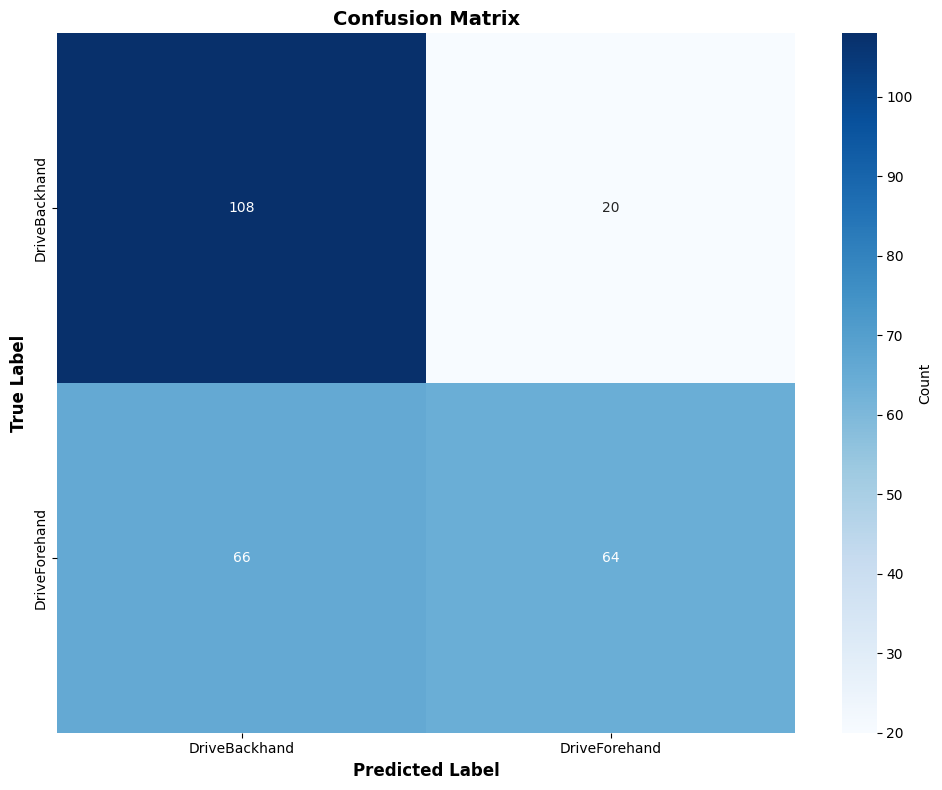

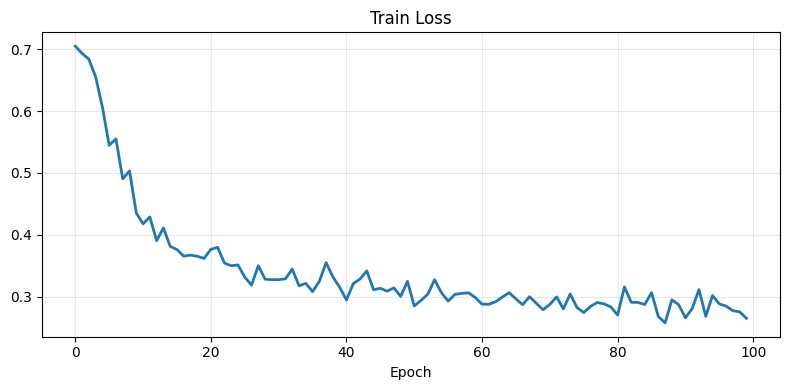

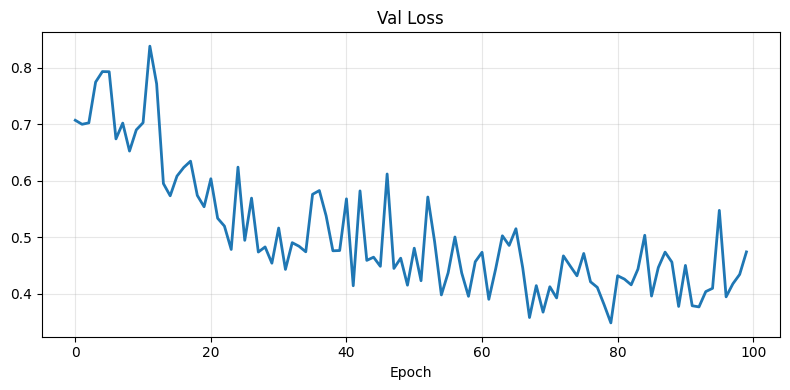

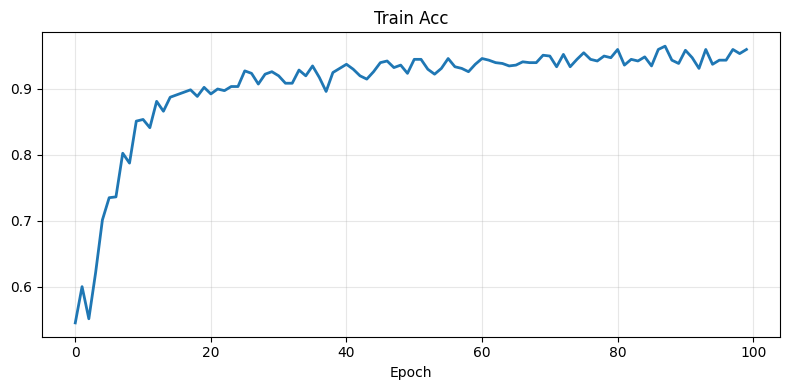

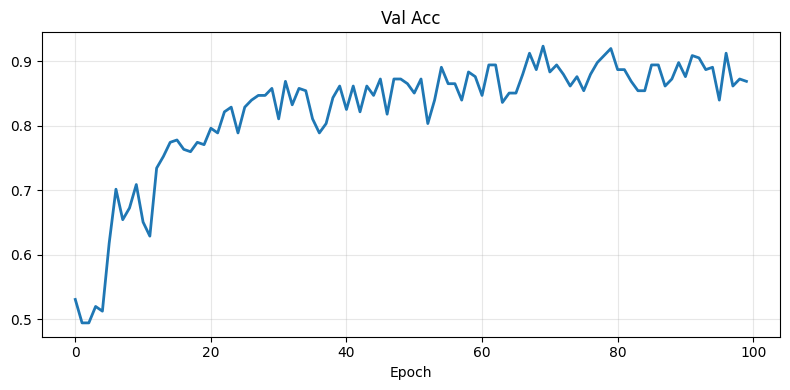

In [28]:
import os, glob, math, json, time, collections, random
import numpy as np
import cv2
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix

# ===============================
# UTILS
# ===============================

def make_dirs(d):
    os.makedirs(d, exist_ok=True)

def timestamp():
    return time.strftime('%Y%m%d_%H%M%S')

# ===============================
# LSTM MODEL
# ===============================

class KeypointLSTMClassifier(nn.Module):
    def __init__(self, feature_dim=51, hidden=128, num_layers=1,
                 num_classes=2, dropout=0.3):
        super().__init__()

        self.lstm = nn.LSTM(
            feature_dim,
            hidden,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(hidden)
        self.classifier = nn.Linear(hidden, num_classes)

    def forward(self, x):
        _, (h, _) = self.lstm(x)
        h = h[-1]
        h = self.dropout(h)
        h = self.ln(h)
        return self.classifier(h)

# ===============================
# EARLY STOPPING
# ===============================

class EarlyStopping:
    def __init__(self, patience=20, min_delta=0.0, mode='min'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
            return False

        improved = (
            score < self.best_score - self.min_delta
            if self.mode == 'min'
            else score > self.best_score + self.min_delta
        )

        if improved:
            self.best_score = score
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

        return self.early_stop

# ===============================
# DATA LOADING
# ===============================

def list_videos(root, classes):
    vids, labels, counts = [], [], {}

    for ci, cname in enumerate(classes):
        p = Path(root) / cname
        if not p.exists():
            print(f"⚠ Warning: {p} does not exist")
            counts[cname] = 0
            continue

        files = (
            list(p.glob('*.mp4')) +
            list(p.glob('*.avi')) +
            list(p.glob('*.MOV'))
        )

        vids.extend([str(f) for f in files])
        labels.extend([ci] * len(files))
        counts[cname] = len(files)

    return vids, labels, counts

# ===============================
# PLOTTING
# ===============================

def plot_training_history(history):
    for key in ['train_loss', 'val_loss', 'train_acc', 'val_acc']:
        plt.figure(figsize=(8, 4))
        plt.plot(history[key], linewidth=2)
        plt.title(key.replace('_', ' ').title())
        plt.xlabel("Epoch")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

def plot_confusion_matrix(cm, classes):
    """Plot confusion matrix heatmap."""
    import matplotlib.pyplot as plt
    import seaborn as sns

    fig, ax = plt.subplots(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes,
                cbar_kws={'label': 'Count'}, ax=ax)

    ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
    ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

# ===============================
# TRAINING FUNCTION
# ===============================

def train_adaptive_model(params):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"\nUsing device: {device}")

    # ===============================
    # LOAD DATA
    # ===============================

    print("\nLoading TRAIN data...")
    train_vids, train_labels, train_counts = list_videos(
        params['train_data_root'], params['classes']
    )
    print("Train:", train_counts)

    print("\nLoading VALIDATION data...")
    val_vids, val_labels, val_counts = list_videos(
        params['val_data_root'], params['classes']
    )
    print("Validation:", val_counts)

    print("\nLoading TEST data...")
    test_vids, test_labels, test_counts = list_videos(
        params['test_data_root'], params['classes']
    )
    print("Test:", test_counts)

    # ===============================
    # FEATURE EXTRACTION (CACHED)
    # ===============================

    extractor = KeypointExtractor(device=device)
    train_cache = VideoFeatureCache(params['train_cache_dir'])
    val_test_cache = VideoFeatureCache(params['val_test_cache_dir'])

    precompute_keypoint_features_adaptive(
        train_vids, extractor, train_cache,
        seq_length=params['seq_length']
    )

    precompute_keypoint_features_adaptive(
        val_vids + test_vids, extractor, val_test_cache,
        seq_length=params['seq_length']
    )

    del extractor
    if device == 'cuda':
        torch.cuda.empty_cache()

    # ===============================
    # DATASETS & LOADERS
    # ===============================

    train_ds = PickleballDataset(
        train_vids, train_labels, train_cache,
        seq_length=params['seq_length'],
        augment=True, feature_dim=51
    )

    val_ds = PickleballDataset(
        val_vids, val_labels, val_test_cache,
        seq_length=params['seq_length'],
        augment=False, feature_dim=51
    )

    test_ds = PickleballDataset(
        test_vids, test_labels, val_test_cache,
        seq_length=params['seq_length'],
        augment=False, feature_dim=51
    )

    train_loader = DataLoader(train_ds, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=params['batch_size'], shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=params['batch_size'], shuffle=False)

    # ===============================
    # MODEL
    # ===============================

    model = KeypointLSTMClassifier(
        feature_dim=51,
        hidden=128,
        num_classes=len(params['classes'])
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=params['lr'], weight_decay=0.01)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    early_stopping = EarlyStopping(patience=20)

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_loss = float('inf')

    # ===============================
    # TRAIN LOOP
    # ===============================

    for epoch in range(params['epochs']):
        print(f"\nEpoch {epoch+1}/{params['epochs']}")

        model.train()
        total_loss, correct, total = 0, 0, 0

        for X, y in tqdm(train_loader, desc="Training", leave=False):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()

            out = model(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct / total

        model.eval()
        val_loss, correct, total = 0, 0, 0

        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                out = model(X)
                loss = criterion(out, y)
                val_loss += loss.item()
                correct += (out.argmax(1) == y).sum().item()
                total += y.size(0)

        val_loss /= len(val_loader)
        val_acc = correct / total

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc*100:.2f}%")
        print(f"Val   Loss: {val_loss:.4f} | Acc: {val_acc*100:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), params['out_dir'] + '/best_model.pth')
            print("✓ Saved best model")

        if early_stopping(val_loss):
            print("⚠ Early stopping")
            break

    # ===============================
    # TEST
    # ===============================

    model.load_state_dict(torch.load(params['out_dir'] + '/best_model.pth'))
    model.eval()

    preds, labels = [], []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            preds.extend(out.argmax(1).cpu().numpy())
            labels.extend(y.cpu().numpy())

    print("\nTEST RESULT")
    print(classification_report(labels, preds, target_names=params['classes']))

    cm = confusion_matrix(labels, preds)
    print("Confusion Matrix:\n", cm)
    plot_confusion_matrix(cm, params['classes'])

    plot_training_history(history)

    return model, history

# ===============================
# MAIN
# ===============================

if __name__ == '__main__':

    params = {
        'train_data_root': '/content/drive/MyDrive/DatasetVideoPickle',
        'val_data_root': '/content/drive/MyDrive/DatasetVideoPickle/VideoValTest/Validation',
        'test_data_root': '/content/drive/MyDrive/DatasetVideoPickle/VideoValTest/Test',

        'classes': ['DriveBackhand', 'DriveForehand'],
        'seq_length': 16,
        'batch_size': 16,
        'lr': 0.001,
        'epochs': 100,

        'out_dir': '/content/drive/MyDrive/keypoint_experiments',
        'train_cache_dir': '/content/drive/MyDrive/cache_train',
        'val_test_cache_dir': '/content/drive/MyDrive/cache_val_test',
    }

    make_dirs(params['out_dir'])
    make_dirs(params['train_cache_dir'])
    make_dirs(params['val_test_cache_dir'])

    model, history = train_adaptive_model(params)


In [ ]:
def demo_predict_video(video_path, model_path, params):
    """
    Robust demo inference on a single video using LSTM keypoint model
    """

    print("\n" + "=" * 60)
    print("VIDEO PREDICTION DEMO")
    print("=" * 60)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # ===============================
    # LOAD PARAMS
    # ===============================
    classes = params["classes"]
    seq_length = params.get("seq_length", 16)
    feature_dim = 51

    # ===============================
    # LOAD MODEL
    # ===============================
    print(f"\nLoading model from: {model_path}")

    model = KeypointLSTMClassifier(
        feature_dim=feature_dim,
        hidden=128,
        num_layers=1,
        num_classes=len(classes),
        dropout=0.3
    ).to(device)

    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()

    print(" Model loaded successfully")

    # ===============================
    # INIT EXTRACTORS
    # ===============================
    extractor = KeypointExtractor(device=device)
    keyframe_extractor = AdaptiveKeyframeExtractor(target_frames=seq_length)

    # ===============================
    # FEATURE EXTRACTION
    # ===============================
    print(f"\nProcessing video: {Path(video_path).name}")

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(" Cannot open video.")
        return None, None

    frame_indices = keyframe_extractor.extract_frame_indices(video_path)

    feats = []

    for idx in tqdm(frame_indices, desc="Extracting keypoints"):
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ok, frame = cap.read()
        if not ok:
            continue

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        feat = extractor.extract(frame)

        # ===============================
        # CRITICAL FIX
        # ===============================
        if feat is None or len(feat) != feature_dim:
            continue

        feats.append(feat.astype(np.float32))

    cap.release()

    if len(feats) == 0:
        print(" No valid keyframes extracted.")
        return None, None

    # ===============================
    # SEQUENCE NORMALIZATION
    # ===============================
    if len(feats) < seq_length:
        last = feats[-1]
        while len(feats) < seq_length:
            feats.append(last.copy())

    feats = feats[:seq_length]

    x = np.stack(feats, axis=0)          # (T, 51)
    x = torch.from_numpy(x).unsqueeze(0) # (1, T, 51)
    x = x.to(device)

    # ===============================
    # INFERENCE
    # ===============================
    print("\nRunning inference...")
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()

    pred_idx = int(np.argmax(probs))
    pred_label = classes[pred_idx]
    confidence = probs[pred_idx] * 100

    # ===============================
    # OUTPUT
    # ===============================
    print("\n" + "=" * 60)
    print("PREDICTION RESULT")
    print("=" * 60)
    print(f" Predicted Action : {pred_label}")
    print(f" Confidence       : {confidence:.2f}%\n")

    print("Class probabilities:")
    for i, cname in enumerate(classes):
        bar = "█" * int(probs[i] * 50)
        print(f"  {cname:18s}: {probs[i]*100:6.2f}% {bar}")

    print("\n" + "=" * 60 + "\n")

    return pred_label, probs

video_path = "/content/drive/MyDrive/DatasetVideoPickle/Video thừa(bị lặp nhiều)/Driveforehand(thừa)/ForeHandNam - Made with Clipchamp (35).mp4"
model_path = "/content/drive/MyDrive/keypoint_experiments/best_model.pth"

demo_predict_video(video_path, model_path, params)



CALIBRATED VIDEO PREDICTION


NameError: name 'KeypointLSTMClassifier' is not defined

In [ ]:
import torch.nn as nn

class KeypointLSTMClassifier(nn.Module):
    def __init__(self, feature_dim, hidden, num_layers, num_classes, dropout):
        super(KeypointLSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(feature_dim, hidden, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.ln = nn.LayerNorm(hidden)
        self.classifier = nn.Linear(hidden, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)

        out = out[:, -1, :]

        out = self.ln(out)
        logits = self.classifier(out)
        return logits

In [ ]:

params = {
    "classes": ["DriveBackhand", "DriveForehand"],
    "seq_length": 16
}
video_path = "/content/7325126391559.mp4"
model_path = "/content/drive/MyDrive/keypoint_experiments/best_model.pth"

def demo_predict_video(video_path, model_path, params):
    print("\n" + "=" * 60)
    print("CALIBRATED VIDEO PREDICTION")
    print("=" * 60)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    classes = params["classes"]
    seq_length = params.get("seq_length", 16)
    feature_dim = 51

    # LOAD MODEL
    model = KeypointLSTMClassifier(
        feature_dim=feature_dim,
        hidden=128,
        num_layers=1,
        num_classes=len(classes),
        dropout=0.3
    ).to(device)

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # FEATURE EXTRACTION
    extractor = KeypointExtractor(device=device)
    keyframe_extractor = AdaptiveKeyframeExtractor(target_frames=seq_length)

    cap = cv2.VideoCapture(video_path)
    frame_indices = keyframe_extractor.extract_frame_indices(video_path)
    feats = []

    for idx in tqdm(frame_indices, desc="Processing Frames"):
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ok, frame = cap.read()
        if not ok: continue

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        feat = extractor.extract(frame_rgb)
        if feat is not None and len(feat) == feature_dim:
            feats.append(feat.astype(np.float32))
    cap.release()

    if len(feats) < 5:
        print("Not having enough keypoints.")
        return None, None

    if len(feats) < seq_length:
        feats += [feats[-1].copy()] * (seq_length - len(feats))
    feats = feats[:seq_length]

    x = torch.from_numpy(np.stack(feats)).unsqueeze(0).to(device)

    T = 2.2

    with torch.no_grad():
        logits = model(x)
        scaled_probs = torch.softmax(logits / T, dim=1)[0].cpu().numpy()

        entropy = -np.sum(scaled_probs * np.log(scaled_probs + 1e-9))
        max_entropy = np.log(len(classes))
        confidence_penalty = 1 - (entropy / max_entropy)

    pred_idx = np.argmax(scaled_probs)
    pred_label = classes[pred_idx]

    final_confidence = scaled_probs[pred_idx] * confidence_penalty * 100

    print("\n" + "=" * 60)
    print(f"Predicted Action : {pred_label}")
    print(f"Calibrated Confidence : {final_confidence:.2f}%")
    print(f"Raw Max Prob (Overconfident): {torch.softmax(logits, dim=1).max().item()*100:.2f}%")
    print("=" * 60)

    for i, cname in enumerate(classes):
        bar = "█" * int(scaled_probs[i] * 50)
        print(f"  {cname:18s}: {scaled_probs[i]*100:6.2f}% {bar}")

    return pred_label, scaled_probs

# THỰC THI
demo_predict_video(video_path, model_path, params)




CALIBRATED VIDEO PREDICTION
Loading YOLO11 Pose model...


Processing Frames: 100%|██████████| 16/16 [00:00<00:00, 27.41it/s]


Predicted Action : DriveForehand
Calibrated Confidence : 30.15%
Raw Max Prob (Overconfident): 97.36%
  DriveBackhand     :  16.24% ████████
  DriveForehand     :  83.76% █████████████████████████████████████████


('DriveForehand', array([     0.1624,      0.8376], dtype=float32))